In [2]:
import glob
import zipfile
import os
import pandas as pd
import re

In [3]:
zipped_file_path = "files.zip"
trojan_zipped_path = "TRIT-TC.zip"
new_stat = "newstat_new.zip"
main_dataset = "newstat_new/"

In [4]:
prob_path = 'probs/'
trojan_inserted_benchmark = "TRIT-TC/"


In [5]:
raw_data = pd.read_pickle("raw_data.pkl")

# Create dataset

In [47]:
logic_gates = ["and", "or", "not", "xor", "xnor", "nand", "nor", "inv"]


def get_line(verilog_path):
    with open(verilog_path, 'r') as file:
        filtered_lines = []
        for line in file:
            line = line.replace("(", "").replace(")", "").replace(";", "").strip()
            words = line.lower().split()
            if words and words[0] in logic_gates:
                if len(words) > 1:
                    words.pop(1)
                filtered_lines.append(" ".join(words))
                
    str_input = ' '.join([str(elem) for elem in filtered_lines])

    return str_input;
        

In [116]:
raw_data_to_append = []

for input_files in os.listdir(main_dataset):
    
    str_input = get_line(main_dataset + input_files)
    label = 0
    
    raw_data_to_append.append({
                'Filename': input_files,
                'Text': str_input,
                'label': label
            })
    
raw_data = pd.DataFrame(raw_data_to_append)


In [117]:
prob_file_name = []

for item in raw_data["Filename"]:
    prob_file_name.append(item.split(".")[0] + "_ProbCntr.txt")

    
raw_data["Prob_Filename"] = prob_file_name



In [118]:
desired_column_order = ['Filename', 'Prob_Filename', 'Text', 'label']

# Reorder the DataFrame columns
raw_data = raw_data[desired_column_order]

In [119]:
raw_data

,Filename,Prob_Filename,Text,label
0,newstat0_1.v,newstat0_1_ProbCntr.txt,"not n464, n68 not n390, n7 not n486, n67 not n...",0
1,newstat1000_1.v,newstat1000_1_ProbCntr.txt,"not n422, n38 not n401, n94 not n516, n92 not ...",0
2,newstat1001_1.v,newstat1001_1_ProbCntr.txt,"not n548, n158 not n431, n47 not n454, n52 not...",0
3,newstat1002_1.v,newstat1002_1_ProbCntr.txt,"not n301, n53 not n438, n33 not n554, n76 not ...",0
4,newstat1003_1.v,newstat1003_1_ProbCntr.txt,"not n361, n103 not n552, n69 not n597, n145 no...",0
...,...,...,...,...
2096,newstat997_1.v,newstat997_1_ProbCntr.txt,"not n549, n90 not n576, n160 not n656, n54 not...",0
2097,newstat998_1.v,newstat998_1_ProbCntr.txt,"not n260, n133 not n215, n36 not n548, n139 no...",0
2098,newstat999_1.v,newstat999_1_ProbCntr.txt,"not n392, n138 not n669, n137 not n373, n103 n...",0
2099,newstat99_1.v,newstat99_1_ProbCntr.txt,"not n336, n123 not n644, n156 not n290, n1 not...",0


# Trojan Probabilites Calculation

In [9]:
def get_numeric_part(prob_string):
    '''
    Preprocessing columns in df to convert string probability values to float values.
    prob_string: String to be converted.
    '''
    start_index = prob_string.index('=') + 1
    numeric_part = prob_string[start_index:].strip()
    numeric_float = float(numeric_part)
    return numeric_float

In [120]:
def find_vul_nodes(prob_path, n):
    '''
    This function takes path for verilog file and finds most vulnerable n nodes.
    prob_path : path for verilog file
    n : number of wanted nodes
    '''
    
    with open(prob_path, 'r') as file:
        first_line = file.readline() 
        data_to_append = []
        for line in file:

            words = line.split(",")
            node = words[0].split(':')[1]
            prob0 = get_numeric_part(words[1])
            prob1 = get_numeric_part(words[2])
            cc0 = get_numeric_part(words[3])
            cc1 = get_numeric_part(words[4])
            vs = prob0 * (1 - cc0 / (cc0 + cc1))
            # print(cc0, cc1)

            data_to_append.append({
                'File': prob_path.split("/")[1],
                'node': node,
                'prob0': prob0,
                'prob1': prob1,
                'CC0' : cc0,
                'CC1' : cc1,
                'Vulnerability_Score' : vs
            })

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data_to_append)
    
    sorted_df = df.sort_values(by="Vulnerability_Score")
    
    
    return sorted_df['node'][-200:-200+n]

In [70]:
for items in raw_data["Prob_Filename"]:
    path = prob_path + items
    print(find_vul_nodes(path, 5))
    break

3063     n4845 
1539     n5139 
4875     n4918 
2236     n5021 
2202     n5003 
Name: node, dtype: object


In [10]:
trojan_lines = []

In [11]:
def extract_until_number(input_string):
    match = re.search(r'[0-9]', input_string)
    
    if match:
        result = input_string[:match.start()]
        return result
    else:
        return input_string

In [121]:
all_trojans = [[]]

for files in os.listdir(trojan_inserted_benchmark):
    
    verilog_file = os.listdir(trojan_inserted_benchmark + files)[0]
    verilog_file_path  = trojan_inserted_benchmark + files + '/' + verilog_file
    
    if verilog_file != ".ipynb_checkpoints":
        trojan_lines = []
        with open(verilog_file_path, 'r') as file:
            for line in file:
                line = line.replace("(", "").replace(")", "").replace(";", "").strip()
                words = line.lower().split()
                if len(words) > 1:
                    if 'troj' in words[1]:
                        
                        if len(words) > 1:
                            words.pop(1)
                        
                        gate_name = extract_until_number(words[0])
                        if gate_name == "nnd":
                            words[0] = "nand"
                        elif gate_name == "i":
                            words[0] = "inv" 
                        elif gate_name in logic_gates:
                            index = logic_gates.index(gate_name)
                            words[0] = logic_gates[index]
                        
                        # to do make trojan gate names valid
                        trojan_lines.append(" ".join(words))
    if verilog_file != ".ipynb_checkpoints":
        all_trojans.append(trojan_lines)

In [122]:
all_trojans.pop(0)

[]

# Injecting Trojans into Dataset

In [13]:
def vulnerable_nodes_number(trojan):
    z = 0 
    for items in trojan:
        # print(items, type(items))
        z += (len(items.split()) - 1)
    return z

In [54]:
raw_data.to_pickle("raw_data.pkl")

In [14]:
raw_data["Prob_Filename"][0]

'newstat0_1_ProbCntr.txt'

In [15]:
raw_data

,Filename,Prob_Filename,Text,label
0,newstat0_1.v,newstat0_1_ProbCntr.txt,"not n464, n68 not n390, n7 not n486, n67 not n...",0
1,newstat1000_1.v,newstat1000_1_ProbCntr.txt,"not n422, n38 not n401, n94 not n516, n92 not ...",0
2,newstat1001_1.v,newstat1001_1_ProbCntr.txt,"not n548, n158 not n431, n47 not n454, n52 not...",0
3,newstat1002_1.v,newstat1002_1_ProbCntr.txt,"not n301, n53 not n438, n33 not n554, n76 not ...",0
4,newstat1003_1.v,newstat1003_1_ProbCntr.txt,"not n361, n103 not n552, n69 not n597, n145 no...",0
...,...,...,...,...
2096,newstat997_1.v,newstat997_1_ProbCntr.txt,"not n549, n90 not n576, n160 not n656, n54 not...",0
2097,newstat998_1.v,newstat998_1_ProbCntr.txt,"not n260, n133 not n215, n36 not n548, n139 no...",0
2098,newstat999_1.v,newstat999_1_ProbCntr.txt,"not n392, n138 not n669, n137 not n373, n103 n...",0
2099,newstat99_1.v,newstat99_1_ProbCntr.txt,"not n336, n123 not n644, n156 not n290, n1 not...",0


In [64]:
raw_data = pd.read_pickle("raw_data.pkl")

In [202]:
len_trojan = len(all_trojans)
half_length = len(raw_data) // 2 

for index, row in raw_data.iloc[:half_length].iterrows():
    troj_index = index
    
    if troj_index >= len_trojan:
        troj_index %= len_trojan 
    # print(troj_index)
    
    
    
    nv_nodes = vulnerable_nodes_number(all_trojans[troj_index])
    v_node_names = find_vul_nodes(prob_path + row["Prob_Filename"], nv_nodes)

    x = 0;
    injected_trojans = []
    
    for items in all_trojans[troj_index]:
        sp_line = items.split()
        for i in range(1,len(sp_line)):
            sp_line[i] = v_node_names.iloc[x]
            x += 1
        line_troj = ' '.join([str(elem) for elem in sp_line])
        injected_trojans.append(line_troj)
        
    str_troj = ' '.join([str(elem) for elem in injected_trojans])
    # print(injected_trojans)
    # print(str_troj)
    
    raw_data.loc[index, 'trojan_inserted_text'] = raw_data.loc[index, 'Text'] + str_troj
    # Change 'Label' value to 1
    raw_data.loc[index, 'label'] = 1
        

In [203]:
desired_column_order = ['Filename', 'Prob_Filename', 'Text','trojan_inserted_text', 'label']

# Reorder the DataFrame columns
raw_data = raw_data[desired_column_order]

In [126]:
raw_data

,Filename,Prob_Filename,Text,trojan_inserted_text,label
0,newstat0_1.v,newstat0_1_ProbCntr.txt,"not n464, n68 not n390, n7 not n486, n67 not n...","not n464, n68 not n390, n7 not n486, n67 not n...",1
1,newstat1000_1.v,newstat1000_1_ProbCntr.txt,"not n422, n38 not n401, n94 not n516, n92 not ...","not n422, n38 not n401, n94 not n516, n92 not ...",1
2,newstat1001_1.v,newstat1001_1_ProbCntr.txt,"not n548, n158 not n431, n47 not n454, n52 not...","not n548, n158 not n431, n47 not n454, n52 not...",1
3,newstat1002_1.v,newstat1002_1_ProbCntr.txt,"not n301, n53 not n438, n33 not n554, n76 not ...","not n301, n53 not n438, n33 not n554, n76 not ...",1
4,newstat1003_1.v,newstat1003_1_ProbCntr.txt,"not n361, n103 not n552, n69 not n597, n145 no...","not n361, n103 not n552, n69 not n597, n145 no...",1
...,...,...,...,...,...
2096,newstat997_1.v,newstat997_1_ProbCntr.txt,"not n549, n90 not n576, n160 not n656, n54 not...",NaN,0
2097,newstat998_1.v,newstat998_1_ProbCntr.txt,"not n260, n133 not n215, n36 not n548, n139 no...",NaN,0
2098,newstat999_1.v,newstat999_1_ProbCntr.txt,"not n392, n138 not n669, n137 not n373, n103 n...",NaN,0
2099,newstat99_1.v,newstat99_1_ProbCntr.txt,"not n336, n123 not n644, n156 not n290, n1 not...",NaN,0


In [204]:
# Fill NaN values in target_column with values from source_column
condition = raw_data['trojan_inserted_text'].isnull()
raw_data.loc[condition, 'trojan_inserted_text'] = raw_data.loc[condition, 'Text']

In [129]:
len(raw_data["Text"][0])

102265

In [130]:
len(raw_data["trojan_inserted_text"][0])

102603

# Model Training Part

In [7]:
import re, string
import nltk
import zipfile
import os
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, multiply, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score,  precision_recall_fscore_support, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import seaborn as sns

In [10]:
raw_data = pd.read_pickle("raw_datav3.pkl")

In [11]:
raw_data

,Filename,Prob_Filename,Text,trojan_inserted_text,label
0,newstat0_1.v,newstat0_1_ProbCntr.txt,"not n464, n68 not n390, n7 not n486, n67 not n...","not n464, n68 not n390, n7 not n486, n67 not n...",1
1,newstat1000_1.v,newstat1000_1_ProbCntr.txt,"not n422, n38 not n401, n94 not n516, n92 not ...","not n422, n38 not n401, n94 not n516, n92 not ...",1
2,newstat1001_1.v,newstat1001_1_ProbCntr.txt,"not n548, n158 not n431, n47 not n454, n52 not...","not n548, n158 not n431, n47 not n454, n52 not...",1
3,newstat1002_1.v,newstat1002_1_ProbCntr.txt,"not n301, n53 not n438, n33 not n554, n76 not ...","not n301, n53 not n438, n33 not n554, n76 not ...",1
4,newstat1003_1.v,newstat1003_1_ProbCntr.txt,"not n361, n103 not n552, n69 not n597, n145 no...","not n361, n103 not n552, n69 not n597, n145 no...",1
...,...,...,...,...,...
2096,newstat997_1.v,newstat997_1_ProbCntr.txt,"not n549, n90 not n576, n160 not n656, n54 not...","not n549, n90 not n576, n160 not n656, n54 not...",0
2097,newstat998_1.v,newstat998_1_ProbCntr.txt,"not n260, n133 not n215, n36 not n548, n139 no...","not n260, n133 not n215, n36 not n548, n139 no...",0
2098,newstat999_1.v,newstat999_1_ProbCntr.txt,"not n392, n138 not n669, n137 not n373, n103 n...","not n392, n138 not n669, n137 not n373, n103 n...",0
2099,newstat99_1.v,newstat99_1_ProbCntr.txt,"not n336, n123 not n644, n156 not n290, n1 not...","not n336, n123 not n644, n156 not n290, n1 not...",0


In [210]:
raw_data = raw_data.sample(frac=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(raw_data["trojan_inserted_text"],raw_data["label"],test_size=0.15, shuffle=True, random_state = 42)

In [13]:
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_train, y_train,stratify=y_train, test_size=0.15, random_state=42) # 0.1 x 0.8

In [14]:
y_train_dl.value_counts()

1    760
0    757
Name: label, dtype: int64

In [15]:
y_val_dl.value_counts()

1    134
0    134
Name: label, dtype: int64

In [16]:
def print_performance_metrics(cm):
    tn, fp, fn, tp = cm.ravel()

    # Calculaabste True Positive Rate (TPR), False Positive Rate (FPR), Accuracy, Precision, Recall, and F1 score
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate Specificity (True Negative Rate, TNR)
    tnr = tn / (tn + fp)

    # Calculate Negative Predictive Value (NPV)
    npv = tn / (tn + fn)

    # Calculate Positive Predictive Value (PPV)
    ppv = tp / (tp + fp)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    # Print the results
    print("Confusion Matrix:")
    print(cm)
    print("True Positives (TP):", tp)
    print("False Positives (FP):", fp)
    print("True Negatives (TN):", tn)
    print("False Negatives (FN):", fn)
    print("True Positive Rate (TPR):", tpr)
    print("False Positive Rate (FPR):", fpr)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    print("Specificity (TNR):", tnr)
    print("Negative Predictive Value (NPV):", npv)
    print("Positive Predictive Value (PPV):", ppv)
    print("Matthews Correlation Coefficient (MCC):", mcc)
            
    # Create a bar plot to visualize TP, FP, TN, FN
    labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    values = [tn, fp, fn, tp]

    # plt.figure(figsize=(8, 6))
    # plt.bar(labels, values, color=['green', 'red', 'orange', 'blue'])
    # plt.xlabel('Confusion Matrix Elements')
    # plt.ylabel('Counts')
    # plt.title('Confusion Matrix')
    # plt.show()

In [17]:
def create_conf_matrix(cf_matrix):
    sns.set(font_scale=1)
    plt.rcParams.update({'font.size': 14})
    plt.rcParams['font.family'] = 'Consolas'

    # Assuming you have defined cf_matrix

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Create the heatmap with custom font and bold text
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontweight": "bold", "fontsize": 12})

    plt.show()

In [18]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(raw_data['trojan_inserted_text'])

In [19]:
X_train_list = X_train_dl.tolist()
X_test_list = X_test.tolist()
X_val_list = X_val_dl.tolist()

In [20]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train_list)
X_test_tokenized = tokenizer.texts_to_sequences(X_test_list)
X_val_tokenized = tokenizer.texts_to_sequences(X_val_list)

In [21]:
max_length = max([len(s.split()) for s in raw_data.Text])

In [22]:
max_length

18241

In [23]:
X_train_token_pad = pad_sequences(X_train_tokenized, maxlen=max_length, padding='post')
X_test_token_pad = pad_sequences(X_test_tokenized, maxlen=max_length, padding='post')
X_val_token_pad = pad_sequences(X_val_tokenized, maxlen=max_length, padding='post')

In [24]:
vocab_size = len(tokenizer.word_index) + 1

In [25]:
vocab_size

5872

In [26]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout
import tensorflow as tf

In [110]:
from keras import backend as K 

# Do some code, e.g. train and save model

tf.keras.backend.clear_session()

In [111]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 96, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())  # Add BatchNormalization layer
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.15))  # Add Dropout layer with 50% dropout rate
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18241, 96)         563712    
                                                                 
 conv1d (Conv1D)             (None, 18234, 32)         24608     
                                                                 
 max_pooling1d (MaxPooling1  (None, 9117, 32)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 9117, 32)          128       
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 291744)            0         
                                                                 
 dense (Dense)               (None, 10)                2

Epoch 1/10
48/48 - 36s - loss: 0.8591 - accuracy: 0.4957 - val_loss: 0.6977 - val_accuracy: 0.5063 - lr: 0.0010 - 36s/epoch - 754ms/step
Epoch 2/10
48/48 - 36s - loss: 0.6760 - accuracy: 0.5023 - val_loss: 0.6953 - val_accuracy: 0.4873 - lr: 0.0010 - 36s/epoch - 741ms/step
Epoch 3/10
48/48 - 35s - loss: 0.6741 - accuracy: 0.5056 - val_loss: 0.6944 - val_accuracy: 0.5063 - lr: 0.0010 - 35s/epoch - 736ms/step
Epoch 4/10
48/48 - 36s - loss: 0.6735 - accuracy: 0.5162 - val_loss: 0.6937 - val_accuracy: 0.5063 - lr: 0.0010 - 36s/epoch - 741ms/step
Epoch 5/10
48/48 - 36s - loss: 0.6756 - accuracy: 0.5135 - val_loss: 0.6933 - val_accuracy: 0.5063 - lr: 0.0010 - 36s/epoch - 744ms/step
Epoch 6/10
48/48 - 35s - loss: 0.6710 - accuracy: 0.5201 - val_loss: 0.6931 - val_accuracy: 0.5032 - lr: 0.0010 - 35s/epoch - 730ms/step
Epoch 7/10
48/48 - 35s - loss: 0.6715 - accuracy: 0.5201 - val_loss: 0.6931 - val_accuracy: 0.5063 - lr: 0.0010 - 35s/epoch - 734ms/step
Epoch 8/10
48/48 - 35s - loss: 0.6685 - a

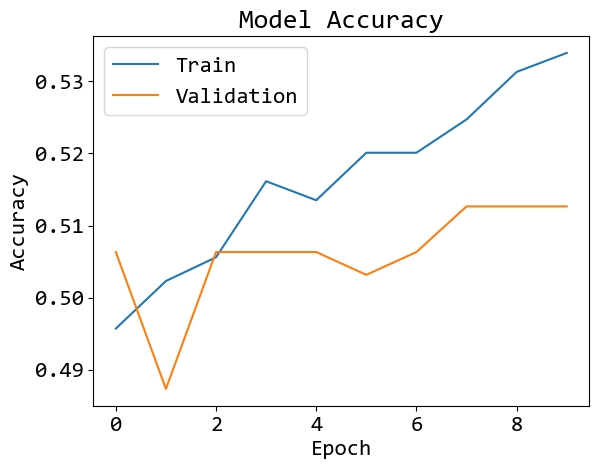

In [112]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
N_epochs = 10
# compile network with Adam optimizer
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# fit network with callbacks
history = model.fit(X_train_token_pad, y_train_dl, epochs=N_epochs, verbose=2,
                    validation_data=(X_test_token_pad, y_test),
                    callbacks=[early_stopping, reduce_lr])

# evaluate on validation set
loss, acc = model.evaluate(X_val_token_pad, y_val_dl, verbose=0)
print('Validation Accuracy: {:.2f}%'.format(acc * 100))

# plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [116]:
train_accuracy = history.history['accuracy']

In [123]:
test_acc

0.5

In [43]:
history.history["loss"]

[0.6930011510848999,
 0.6670970320701599,
 0.6544323563575745,
 0.6502887010574341,
 0.6497695446014404,
 0.6512656807899475,
 0.6517837047576904,
 0.6546959280967712,
 0.65065598487854,
 0.6506785154342651]

In [115]:
validation_accuracy = history.history['val_accuracy']

In [122]:
test_acc = acc

In [40]:
validation_accuracy

[0.503164529800415, 0.5126582384109497, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [39]:
train_accuracy

[0.49505603313446045,
 0.521423876285553,
 0.5207646489143372,
 0.5365853905677795,
 0.5379037857055664,
 0.5339486002922058,
 0.53328937292099,
 0.5306525826454163,
 0.5359261631965637,
 0.5339486002922058]

In [38]:
test_acc

0.5074626803398132

In [162]:
raw_data['Text_len'] = raw_data['Text'].apply(lambda x: len(x))

In [164]:
raw_data['trojen_inserted_text_len'] = raw_data['trojan_inserted_text'].apply(lambda x: len(x))

In [165]:
raw_data

,Filename,Prob_Filename,Text,trojan_inserted_text,label,Text_len,trojen_inserted_text_len
424,newstat1382_1.v,newstat1382_1_ProbCntr.txt,"not n645, n21 not n561, n164 not n355, n1 not ...","not n645, n21 not n561, n164 not n355, n1 not ...",1,101119,101346
444,newstat13_1.v,newstat13_1_ProbCntr.txt,"not n615, n75 not n433, n165 not n464, n57 not...","not n615, n75 not n433, n165 not n464, n57 not...",1,100954,101395
1413,newstat381_1.v,newstat381_1_ProbCntr.txt,"not n256, n138 not n573, n6 not n700, n76 not ...","not n256, n138 not n573, n6 not n700, n76 not ...",0,100360,100360
512,newstat1461_1.v,newstat1461_1_ProbCntr.txt,"not n530, n98 not n685, n145 not n389, n60 not...","not n530, n98 not n685, n145 not n389, n60 not...",1,102257,102527
473,newstat1426_1.v,newstat1426_1_ProbCntr.txt,"not n315, n87 not n284, n121 not n293, n69 not...","not n315, n87 not n284, n121 not n293, n69 not...",1,101039,101303
...,...,...,...,...,...,...,...
1329,newstat305_1.v,newstat305_1_ProbCntr.txt,"not n255, n151 not n698, n17 not n367, n25 not...","not n255, n151 not n698, n17 not n367, n25 not...",0,98442,98442
687,newstat1619_1.v,newstat1619_1_ProbCntr.txt,"not n297, n87 not n588, n3 not n384, n106 not ...","not n297, n87 not n588, n3 not n384, n106 not ...",1,101259,101458
826,newstat1744_1.v,newstat1744_1_ProbCntr.txt,"not n683, n102 not n348, n97 not n298, n166 no...","not n683, n102 not n348, n97 not n298, n166 no...",1,101216,101430
585,newstat1527_1.v,newstat1527_1_ProbCntr.txt,"not n502, n159 not n591, n99 not n224, n63 not...","not n502, n159 not n591, n99 not n224, n63 not...",1,101147,101406


In [171]:
len(X_test_token_pad)

316

In [172]:
len(X_val_token_pad)

268

In [176]:
type(X_test_token_pad[0])

numpy.ndarray

In [184]:
test = []
for item in X_train_token_pad:
    test.append(np.count_nonzero(item == 0))

In [186]:
average = sum(test) / len(test)

In [187]:
average

976.659195781147

In [182]:
value_count = np.count_nonzero(X_train_token_pad == 0)

In [183]:
value_count

1481592

In [ ]:
unique_values, frequencies = np.unique(X_test_token_pad[0], return_counts=True)

for value, frequency in zip(unique_values, frequencies):
    print(f"Value: {value}, Frequency: {frequency}")

In [ ]:
raw_data["Text_Len"] = 

In [113]:
val_loss = history.history["val_loss"]

In [114]:
train_loss = history.history["loss"]

In [ ]:
train_accuracy
validation_accuracy
test_acc

In [55]:
epochs = [1,2,3,4,5,6,7,8,9,10]

In [48]:
len(train_accuracy)

10

In [51]:
train_loss

[0.6930011510848999,
 0.6670970320701599,
 0.6544323563575745,
 0.6502887010574341,
 0.6497695446014404,
 0.6512656807899475,
 0.6517837047576904,
 0.6546959280967712,
 0.65065598487854,
 0.6506785154342651]

In [126]:
data = {
    'train_accuracy': train_accuracy,
    'train_loss': train_loss,
    'validation_accuracy': validation_accuracy,
    'val_loss': val_loss,
    'test_acc' : test_acc
}

# Create a DataFrame
df_96_results = pd.DataFrame(data)

In [127]:
df_96_results.to_pickle("df_96_results.pkl")

In [139]:
train_accuracy = df_48_results["train_accuracy"]
train_loss = df_48_results["train_loss"]
validation_accuracy = df_48_results["validation_accuracy"]
val_loss = df_48_results["val_loss"]
test_acc = df_48_results["test_acc"]

In [ ]:
train_accuracy = train_accuracy.tolist()
train_loss  = train_loss.tolist()
validation_accuracy = validation_accuracy.tolist()
val_loss = val_loss.tolist()


In [165]:
test_acc = test_acc[0]

In [152]:
from matplotlib.ticker import FuncFormatter

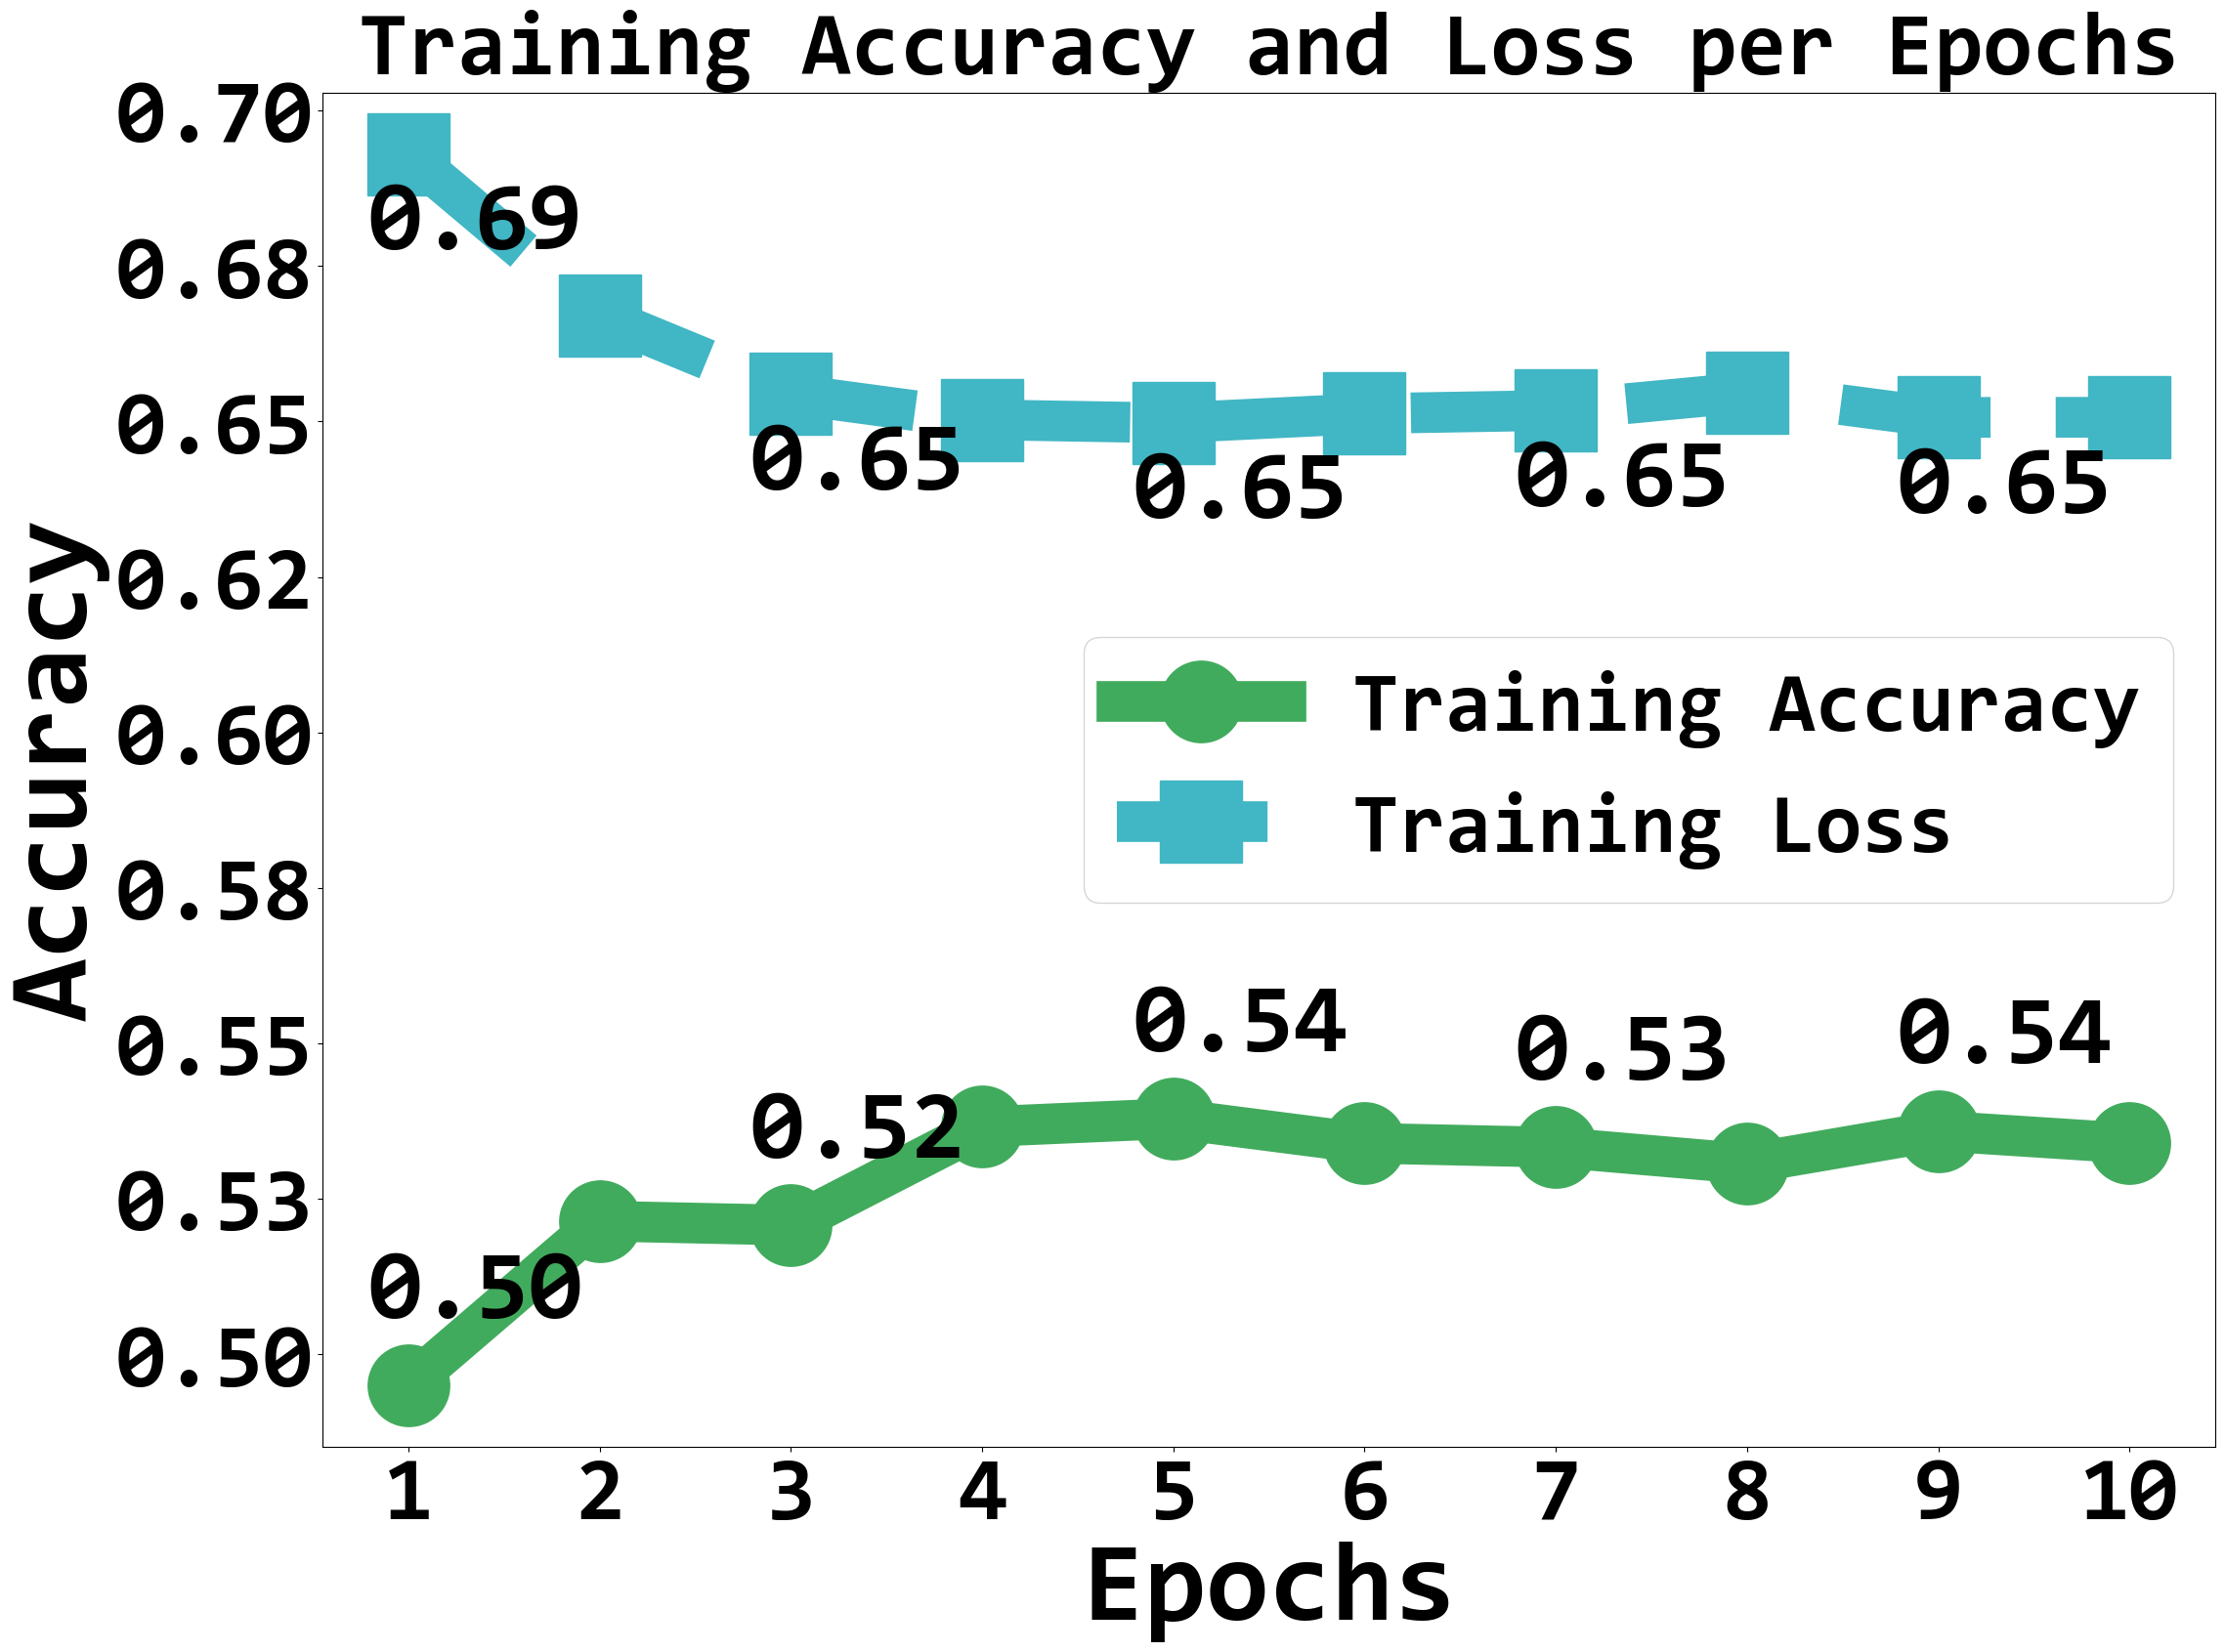

In [161]:
plt.figure(figsize=(25, 18), facecolor='white')  # Adjust the figure size
# plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ax = plt.axes()
ax.set_facecolor('white')
# Plot training accuracy
plt.plot(epochs, train_accuracy, marker='o', linestyle='-', linewidth=30, markersize=60,color = '#41ab5d', label='Training Accuracy')
plt.plot(epochs,train_loss, marker='s', linestyle='--', linewidth=30,  color='#41b6c4', markersize=60, label='Training Loss')

plt.xlabel('Epochs', fontsize=84, fontweight='bold')
plt.ylabel('Accuracy', fontsize = 84, fontweight='bold')
plt.title('Training Accuracy and Loss per Epochs', fontsize=66, fontweight='bold')
plt.grid(False)

plt.xticks(epochs, fontweight = 'bold', fontsize = 66)  # Set the x-axis ticks to match the epochs
plt.yticks(fontweight='bold', fontsize = 66)  # Use fontweight parameter to make the y-axis tick labels bold
# Add a horizontal line for maximum validation accuracy (optional)
legend_font = {'weight': 'bold', 'size': 62}  # Customize font size and weight
legend = plt.legend(prop=legend_font)  # Set the legend position and font properties

for i, acc in enumerate(train_accuracy):
    if i % 2 == 0:  # Only annotate every 2 points
        plt.annotate(f'{acc:.2f}', xy=(epochs[i], acc), xytext=(-30, 50), textcoords='offset points', fontweight='bold', fontsize=72)

for i, loss in enumerate(train_loss):
    if i % 2 == 0:  # Only annotate every 2 points
        plt.annotate(f'{loss:.2f}', xy=(epochs[i], loss), xytext=(-30, -70), textcoords='offset points', fontweight='bold', fontsize=72)
        
# Customize y-axis tick formatting
def format_accuracy(y, pos):
    return f'{y:.2f}'  # Format to two decimal places

ax.yaxis.set_major_formatter(FuncFormatter(format_accuracy))



plt.savefig('verilog_48_train.png', dpi=800) 

plt.show()

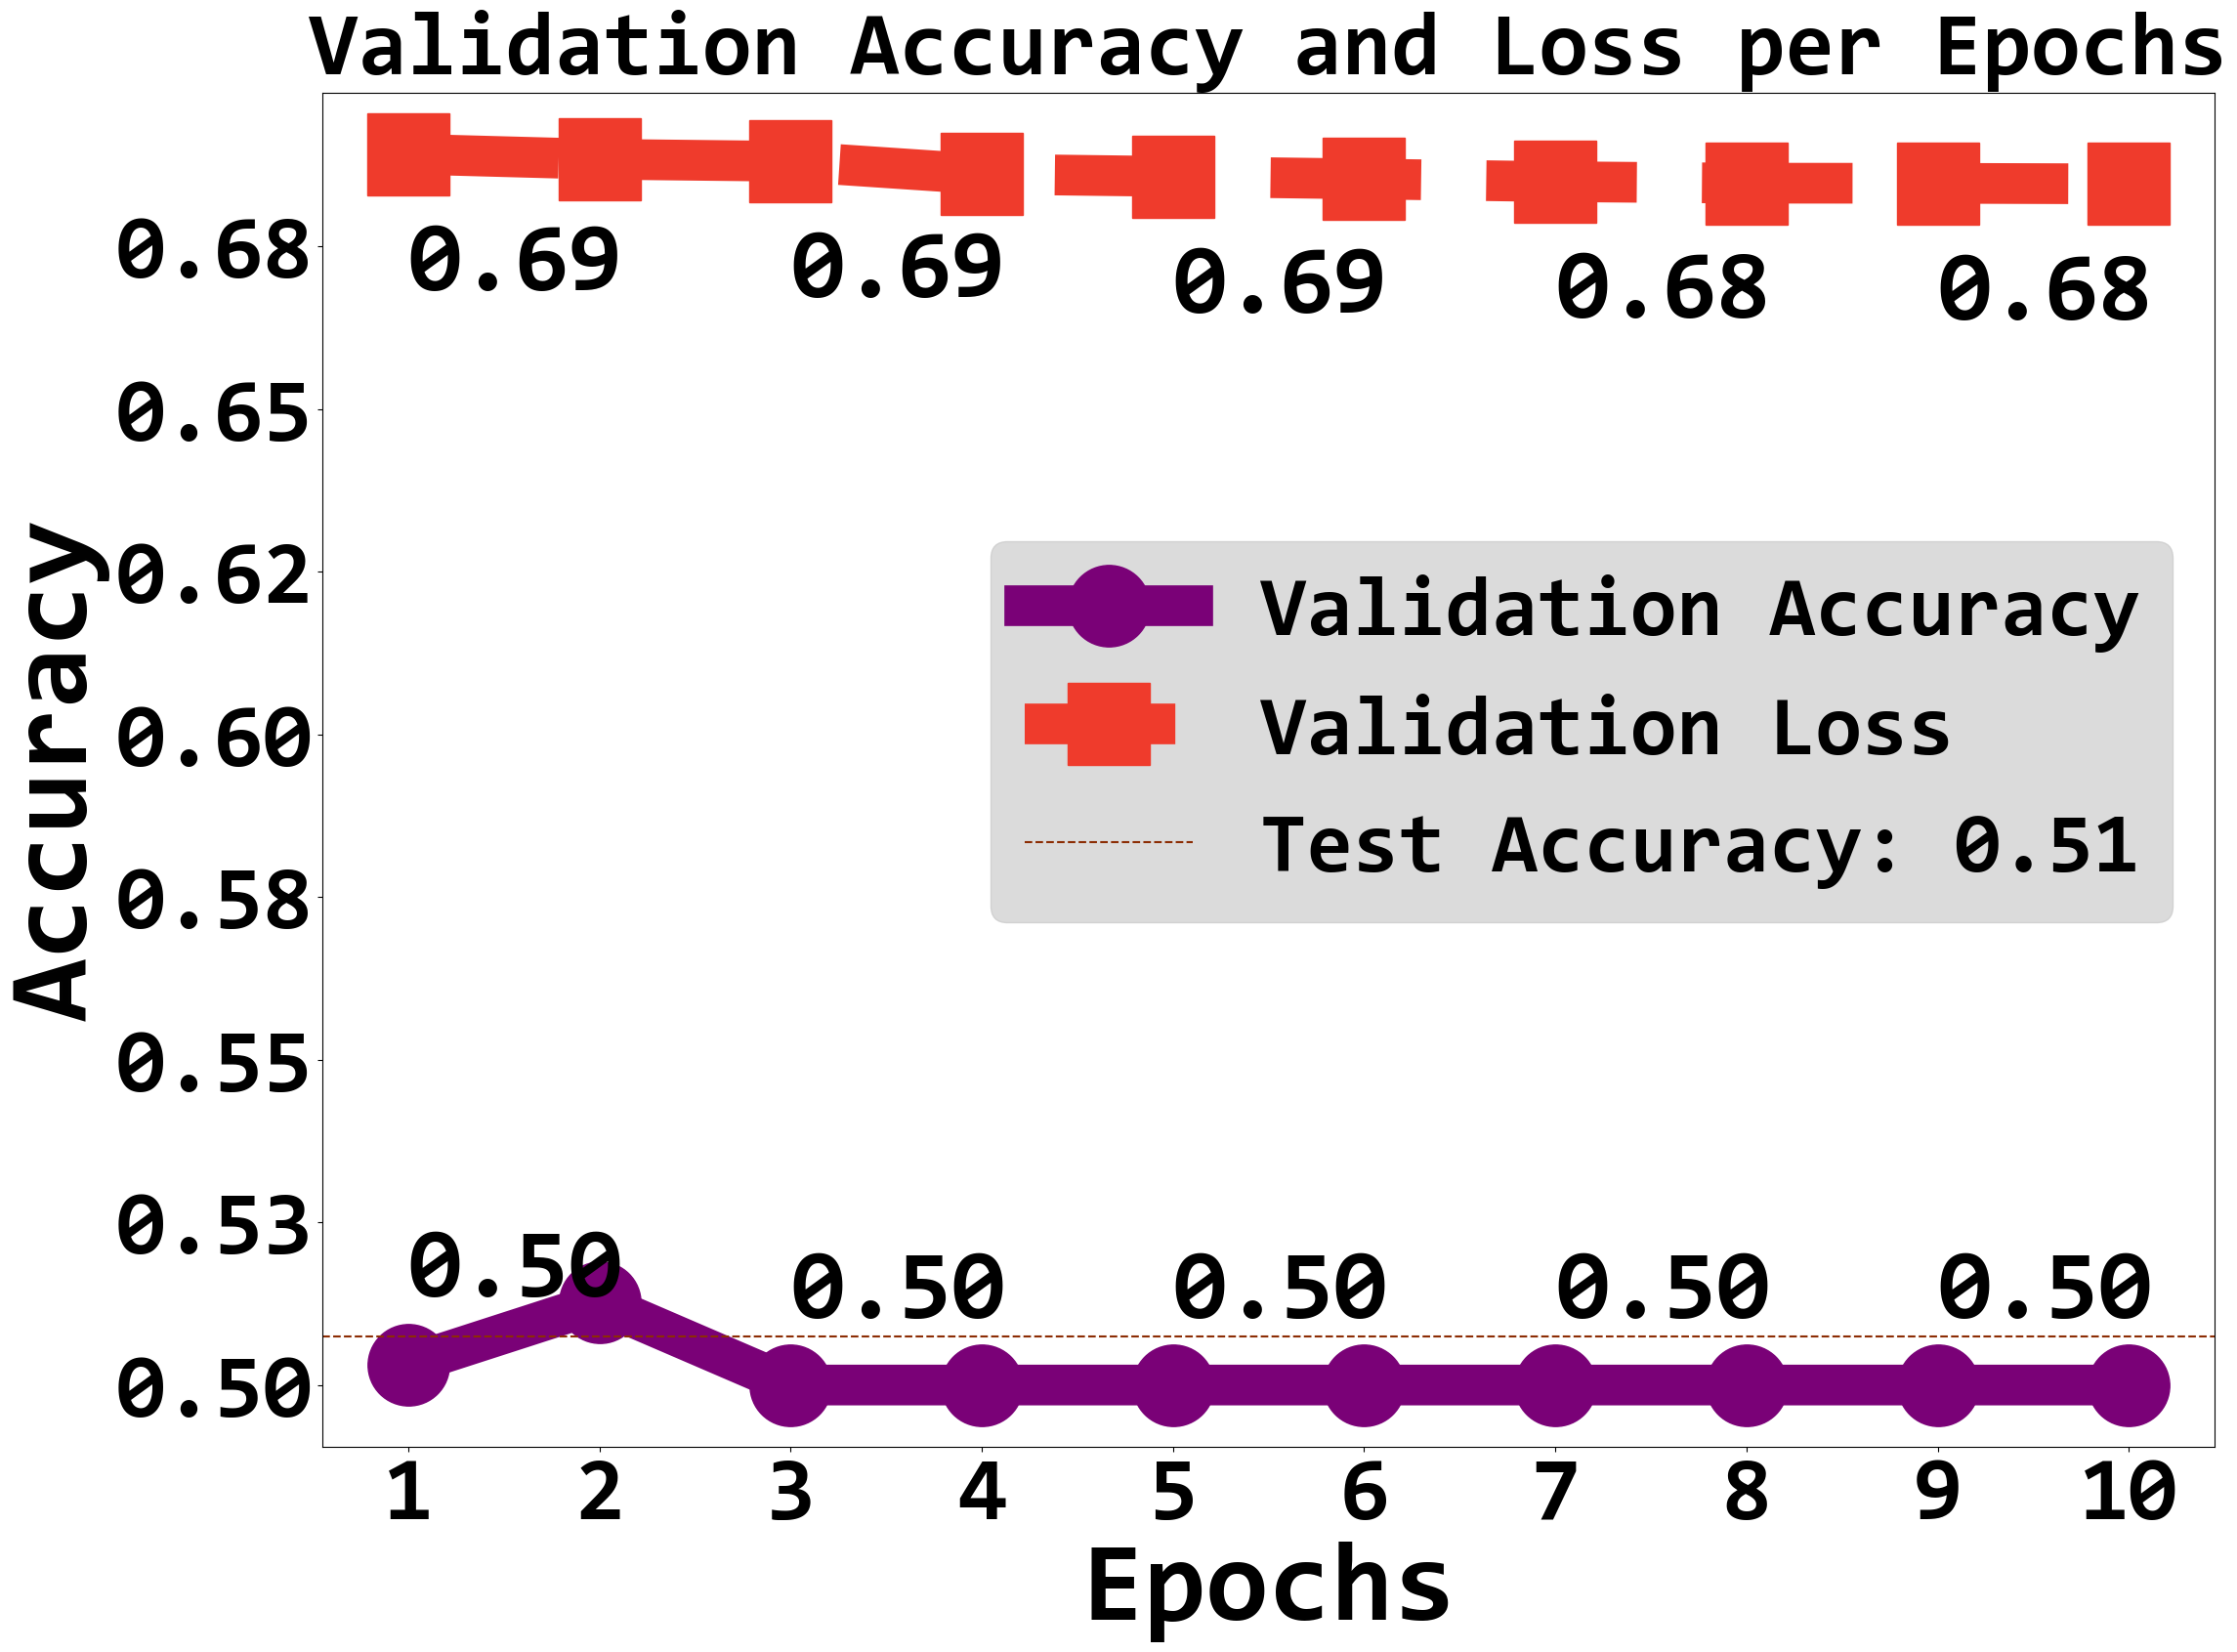

In [167]:
# Set the font size for the plot
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'Consolas'

# After plotting the data
# Create the plot
plt.figure(figsize=(25, 18), facecolor='white')  # Adjust the figure size
ax = plt.axes()
ax.set_facecolor('white')
plt.plot(epochs, validation_accuracy, marker='o', linestyle='-', linewidth=30, color='#7a0177', markersize=60, label='Validation Accuracy')
plt.plot(epochs, val_loss, marker='s', linestyle='--', linewidth=30, color='#ef3b2c', markersize=60, label='Validation Loss')

plt.xlabel('Epochs', fontsize=84, fontweight='bold')
plt.ylabel('Accuracy', fontsize = 84, fontweight='bold')
plt.title('Validation Accuracy and Loss per Epochs', fontsize=66, fontweight='bold')
plt.grid(False)


plt.xticks(epochs, fontweight = 'bold', fontsize = 66)  # Set the x-axis ticks to match the epochs
plt.yticks(fontweight='bold', fontsize = 66)  # Use fontweight parameter to make the y-axis tick labels bold
# Add a horizontal line for maximum validation accuracy (optional)

max_val_accuracy = max(validation_accuracy)
# plt.axhline(y=max_val_accuracy, color='gray', linestyle='--', label=f'Max Val. Accuracy: {max_val_accuracy:.2f}')
plt.axhline(y=test_acc, color='#8c2d04', linestyle='--', label=f'Test Accuracy: {test_acc:.2f}')
# plt.legend(prop={'weight': 'bold'}, fontsize = 36)
legend_font = {'weight': 'bold', 'size': 62}  # Customize font size and weight
legend = plt.legend(prop=legend_font)  # Set the legend position and font properties
legend.set_bbox_to_anchor((1, 0.70)) 
legend.get_frame().set_facecolor('lightgray')


for i, acc in enumerate(validation_accuracy):
    if i % 2 == 0:  # Only annotate every 2 points
        plt.annotate(f'{acc:.2f}', xy=(epochs[i], acc), xytext=(0, 50), textcoords='offset points', fontweight='bold', fontsize=72)

for i, loss in enumerate(val_loss):
    if i % 2 == 0:  # Only annotate every 2 points
        plt.annotate(f'{loss:.2f}', xy=(epochs[i], loss), xytext=(0, -100), textcoords='offset points', fontweight='bold', fontsize=72)
        
# Customize y-axis tick formatting
def format_accuracy(y, pos):
    return f'{y:.2f}'  # Format to two decimal places

ax.yaxis.set_major_formatter(FuncFormatter(format_accuracy))
    
plt.savefig('verilog_48_val.png', dpi=600)  # Specify a higher DPI value (e.g., 300)
plt.show()